<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/Newsletter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-290376198.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='H')


Random Forest MAE on test set: 1.78 kW


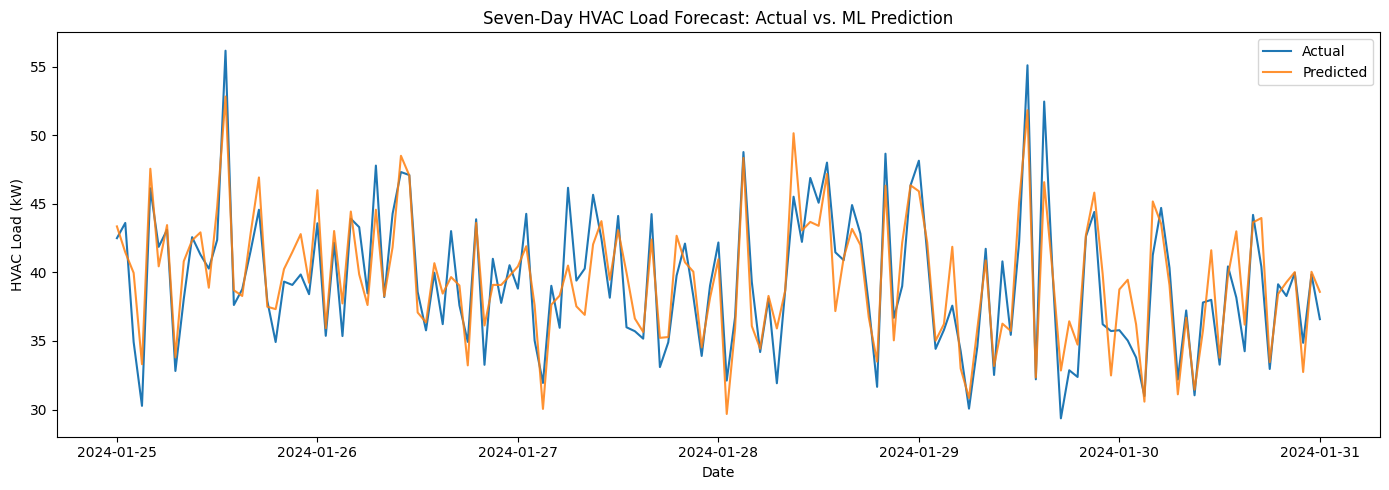

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Generate synthetic building data for one month, hourly intervals
np.random.seed(0)
dates = pd.date_range(start='2024-01-01', end='2024-01-31', freq='H')
temp_out = 10 + 15 * np.sin((dates.dayofyear - 80) * 2 * np.pi / 365) + np.random.normal(0, 3, len(dates))
hour = dates.hour
occupancy = ((hour >= 9) & (hour <= 17)).astype(int)

# Model: base + (heating_x if cold) + (cooling_y if hot) + occupancy + random
base_load = 5
heating_load = np.maximum(20 - temp_out, 0) * 1.5
cooling_load = np.maximum(temp_out - 25, 0) * 2.0
occupancy_load = occupancy * 3.0
hvac_load = base_load + heating_load + cooling_load + occupancy_load + np.random.normal(0, 2, len(dates))

df = pd.DataFrame({
    'datetime': dates,
    'temp_outdoor': temp_out,
    'hour': hour,
    'occupancy': occupancy,
    'hvac_load': hvac_load
})

# Feature engineering: capture need for heating/cooling explicitly
df['heat_demand'] = np.maximum(20 - df['temp_outdoor'], 0)
df['cool_demand'] = np.maximum(df['temp_outdoor'] - 25, 0)

# Training and test split
features = ['heat_demand', 'cool_demand', 'hour', 'occupancy']
n_train = int(0.8 * len(df))
train, test = df.iloc[:n_train], df.iloc[n_train:]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train[features], train['hvac_load'])
preds = rf.predict(test[features])

# Evaluation
mae = mean_absolute_error(test['hvac_load'], preds)
print(f"Random Forest MAE on test set: {mae:.2f} kW")

# Visualization
plt.figure(figsize=(14,5))
plt.plot(test['datetime'][:168], test['hvac_load'][:168], label='Actual')
plt.plot(test['datetime'][:168], preds[:168], label='Predicted', alpha=0.85)
plt.xlabel('Date')
plt.ylabel('HVAC Load (kW)')
plt.title('Seven-Day HVAC Load Forecast: Actual vs. ML Prediction')
plt.legend()
plt.tight_layout()
plt.show()
